# Combine spectroscopic properties, rotation periods and distances to get precise ages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner
import h5py

Load the crossmatched data file with Gaia data, CKS spectroscopic properties and rotation periods.

In [2]:
df1 = pd.read_csv("kane_cks_tdmra_dr2.csv")

# Load the Sanders catalogue and merge with the CKS one.
file = "gaia_spectro.hdf5"
data = Table.read(file)
sanders = data.to_pandas()
df2 = pd.merge(df1, sanders, on="source_id", suffixes=["", "_sanders"])

In [3]:
def distance_modulus(m, parallax_mas):
    D_pc = 1./(parallax_mas * 1e-3)
    return m + 5 - 5*np.log10(D_pc)

CKS/rotation period sample.

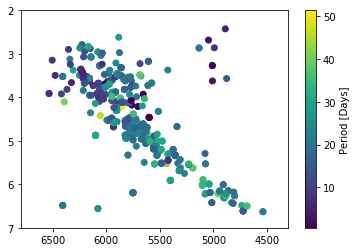

In [4]:
plt.scatter(df1.teff, distance_modulus(df1.phot_g_mean_mag, df1.parallax), c=df1.period)
plt.ylim(7, 2)
plt.xlim(6800, 4300)
plt.colorbar(label="Period [Days]")

CKS/rotation period/Sanders sample

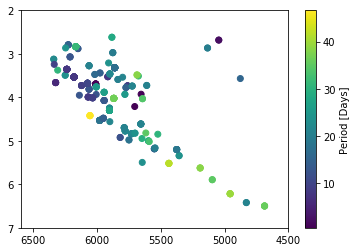

In [5]:
plt.scatter(df2.teff, distance_modulus(df2.phot_g_mean_mag, df2.parallax), c=df2.period)
plt.ylim(7, 2)
plt.xlim(6600, 4500)
plt.colorbar(label="Period [Days]")

Cut out giants.

(144, 306) (37, 306)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


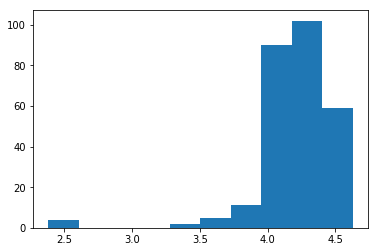

In [6]:
plt.hist(df2.logg.values[np.isfinite(df2.logg.values)]);

m = 4.2 < df2.logg.values
m &= df2.teff.values < 6250
df3 = df2.iloc[m]

# Cut out duplicates
_, inds = np.unique(df3.source_id.values, return_index=True)
df = df3.iloc[inds]

print(np.shape(df3), np.shape(df))

37 37


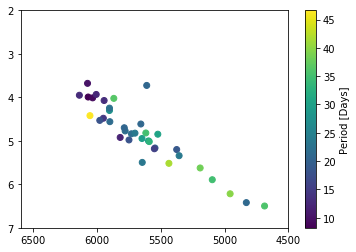

In [7]:
plt.scatter(df.teff, distance_modulus(df.phot_g_mean_mag, df.parallax), c=df.period)
plt.ylim(7, 2)
plt.xlim(6600, 4500)
plt.colorbar(label="Period [Days]")

print(len(df.source_id), len(np.unique(df.source_id.values)))


In [8]:
# for name in df.keys():
#     print(name)

Calculate B-V colours for Gaia stars using their Bp-Rp colours.

In [9]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3

def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    # plt.plot(bprp_pred, diffs**2)
    return bv_iter[np.argmin(diffs**2)]

bv_color = []
for i in range(np.shape(df)[0]):
    bv_color.append(bprp_2_bv(df.phot_bp_mean_mag.values[i] - df.phot_rp_mean_mag.values[i]))
df["BV_color"] = np.array(bv_color)

df.to_csv("sanders_xmatch.csv")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Combine isochrones.py with a gyro model to get ages.

In [10]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

#i = 0  # Just run on the first star.

def setup(df, i, gyro_only=False, iso_only=False):
    print("Source_id = ", df.source_id.values[i])

    # Set the initial values
    mass_init = df.iso_smass.values[i]
    age_init = 2e9
    feh_init = df.cks_smet.values[i]
    distance_init = 1./df.parallax.values[i]
    Av_init = .1

    # sample in ln(mass), log10(age) and ln(distance).
    p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

    # Set up the StarModel object needed to calculate the likelihood. 
    param_dict = {"J": (df.jmag.values[i], df.jmag.values[i]*.05),
                  "H": (df.hmag.values[i], df.hmag.values[i]*.05),
                  "K": (df.kmag.values[i], df.kmag.values[i]*.05),
                  "teff": (df.cks_steff.values[i], df.cks_steff_err1.values[i]),
                  "logg": (df.cks_slogg.values[i], df.cks_slogg_err1.values[i]),
                  "feh": (df.cks_smet.values[i], df.cks_smet_err1.values[i]),
                  "parallax": (df.parallax.values[i],
                               (df.parallax_error.values[i]))}  # Isochrones.py takes milliarcseconds


    print("Teff: ", df.cks_steff.values[i])
    print("logg: ", df.cks_slogg.values[i])
    print("feh: ", df.cks_smet.values[i])
    print("period: ", df.period.values[i])

    
#     # test with Solar values
#     param_dict = {"V": (4.83, .01),
#                   "teff": (5770, 10),
#                   "logg": (4.44, .05),
#                   "feh": (0, .01),
#                   "parallax": (100, 1)
#                  }  # Isochrones.py takes milliarcseconds


    mod = StarModel(mist, **param_dict)
    
    args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i], gyro_only, iso_only]
    
    # test with Solar values.
    #args = [mod, 26, 1, .65, gyro_only, iso_only]
    
    return mod, param_dict, p_init, args

mod, param_dict, p_init, args = setup(df, 0, gyro_only=False, iso_only=False)

Source_id =  2.0511054108162184e+18
Teff:  5078.4
logg:  4.535
feh:  0.16899999999999998
period:  34.96178268569573


Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [11]:
def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [12]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    B = mist.mag["B"](*params)
    V = mist.mag["V"](*params)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
            return mod.lnlike(params) + gyro_lnlike + lnpr
            #return lnpr

Run the MCMC.

In [17]:
def run_mcmc(df, i, suffix="", ndim=5, nwalkers=24, gyro_only=False, iso_only=False):
    
    print("Setting up star {}...".format(i))
    mod, param_dict, p_init, args = setup(df, i, gyro_only=gyro_only, iso_only=iso_only)
    
    p0 = [p_init + np.random.randn(ndim)*1e-4 for k in range(nwalkers)]

    print("Burning in...")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
    p0, _, _ = sampler.run_mcmc(p0, 5000);
    
    print("Plotting burnin chains...")
    for j in range(ndim):
        plt.subplot(ndim, 1, j+1)
        plt.plot(sampler.chain[:, :, j].T, "k", alpha=.1)
        plt.savefig("results/{0}_burnin{1}".format(i, suffix))
        plt.close()

    print("Production run...")
    sampler.reset()
    sampler.run_mcmc(p0, 10000);
    
    make_plots(sampler, i, ndim, suffix)
    
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = 10**samples[:, 1]*1e-9
    
    print("Saving samples...")
    with h5py.File("samples/{0}_{1}.h5".format(i, suffix), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
    
    print("\n")
    return samples


def make_plots(sampler, i, ndim, suffix=""):
    print("Plotting production chains...")
    for j in range(ndim):
        plt.subplot(ndim, 1, j+1)
        plt.plot(sampler.chain[:, :, j].T, "k", alpha=.1)
        plt.savefig("results/{0}_chains{1}".format(i, suffix))
        plt.close()
    
    print("Making corner plot...")
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = (10**samples[:, 1])*1e-9
    
    labels = ["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]
    corner.corner(samples, labels=labels);
    plt.savefig("results/{0}_corner{1}".format(i, suffix))
    plt.close()
    
    print("Plotting age posterior")
    age_gyr = samples[:, 1]
    plt.hist(age_gyr)
    plt.xlabel("Age [Gyr]")
    med, std = np.median(age_gyr), np.std(age_gyr)
    print("age = ", med, "+/-", std)
    plt.axvline(med, color="k")
    #plt.axvline(4.603, color="tab:orange")
    plt.axvline(med - std, color="k", linestyle="--")
    plt.axvline(med + std, color="k", linestyle="--")
    plt.savefig("results/{0}_marginal_age{1}".format(i, suffix))
    plt.close()
    print("age = ", med)

In [18]:
# for i in range(30):
#     print("star number ", i)
#     run_mcmc(df, i, suffix="", gyro_only=False, iso_only=False)
    
# for i in range(5):
#     print("star number ", i, "_gyro")
#     run_mcmc(df, i, suffix="_gyro", gyro_only=True, iso_only=False) 
    
for i in range(4, 30):
    print("star number ", i, "_iso")
    run_mcmc(df, i, suffix="_iso", gyro_only=False, iso_only=True)

star number  4 _iso
Setting up star 4...
Source_id =  2.0527471191156204e+18
Teff:  5593.6
logg:  4.414
feh:  -0.092
period:  29.625925370591144
Burning in...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  5.927332328975815 +/- 3.870277049998467
age =  5.927332328975815
Saving samples...


star number  5 _iso
Setting up star 5...
Source_id =  2.0732772002376945e+18
Teff:  4931.8
logg:  4.484
feh:  0.285
period:  39.72376624264529
Burning in...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/Users/ruthangus/projects/habitablezoning/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2


Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  6.804476454273617 +/- 4.046796296884392
age =  6.804476454273617
Saving samples...


star number  6 _iso
Setting up star 6...
Source_id =  2.0751121090393787e+18
Teff:  5234.9
logg:  4.459
feh:  0.256
period:  38.348372409342396
Burning in...
Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  6.507004276268071 +/- 3.9944988020354915
age =  6.507004276268071
Saving samples...


star number  7 _iso
Setting up star 7...
Source_id =  2.075377679763354e+18
Teff:  5815.7
logg:  4.597
feh:  -0.016
period:  11.973106099309135
Burning in...
Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  3.250155305894584 +/- 3.4764661364049068
age =  3.250155305894584
Saving samples...


star number  8 _iso
Setting up star 8...
Source_i

Plotting age posterior
age =  0.45348402628456674 +/- 3.05323035091726
age =  0.45348402628456674
Saving samples...


star number  16 _iso
Setting up star 16...
Source_id =  2.1024542530975544e+18
Teff:  5760.4
logg:  4.365
feh:  -0.422
period:  18.031474143058034
Burning in...
Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  6.200429124632329 +/- 3.954400370858755
age =  6.200429124632329
Saving samples...


star number  17 _iso
Setting up star 17...
Source_id =  2.104839471773324e+18
Teff:  6182.5
logg:  4.3260000000000005
feh:  -0.134
period:  8.210000115943691
Burning in...
Plotting burnin chains...
Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  4.425065153264212 +/- 3.730693648552965
age =  4.425065153264212
Saving samples...


star number  18 _iso
Setting up star 18...
Source_id =  2.1066740713447227e+18
Teff:  5347.7
logg:  4.589
feh:  -0.248
period: 

Load the results.

In [ ]:
med, std = [], []

Ns = 5
for star in range(Ns):
    fname = "samples/{0}.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        age_gyr = 10**samples[:, 1]*1e-9
        med.append(np.median(age_gyr))
        std.append(np.std(age_gyr))

In [ ]:
# plt.errorbar(df.koi_sage.values[:Ns], med,
#              xerr=[df.koi_sage_err1[:Ns], df.koi_sage_err2[:Ns]],
#              yerr=std,
#              fmt=".")
# plt.xlabel("KIC age [Gyr]")
# plt.ylabel("This work age [Gyr]")

In [ ]:
# print(df.iso_sage.values[:Ns])
# csk_age = 10**df.iso_sage.values[:Ns]
# csk_age_err = 10**(df.iso_sage.values[:Ns] + df.log10_age_err) - sanders_age
# plt.errorbar((10**df.iso_sage.values[:Ns])*1e-9, med,
#              #xerr=[df.iso_sage_err1[:Ns], df.iso_sage_err2[:Ns]],
#              yerr=std,
#              fmt=".")
# print(df.iso_sage_err1[:Ns], df.iso_sage_err2[:Ns])
# plt.xlabel("CKS age [Gyr]")
# plt.ylabel("This work age [Gyr]")

In [ ]:
sanders_age = 10**df.log10_age
sanders_age_err = 10**(df.log10_age + df.log10_age_err) - sanders_age

plt.errorbar(sanders_age[:Ns], med,
             xerr=sanders_age_err[:Ns],
             yerr=std,
             fmt=".")

xs = np.linspace(0, 10, 100)
plt.plot(xs, xs, "k--")
plt.xlabel("Sanders age [Gyr]")
plt.ylabel("This work age [Gyr]")

In [ ]:
# gyro_med, gyro_std = [], []
# Ns = 5
# for star in range(Ns):
#     fname = "samples/{0}__gyro.h5".format(star)
#     with h5py.File(fname, "r") as f:
#         samples = f["samples"][...]
#         gyro_med.append(np.median(age_gyr))
#         gyro_std.append(np.std(age_gyr))
        
iso_med, iso_std = [], []
Ns = 5
for star in range(Ns):
    fname = "samples/{0}__iso.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        iso_med.append(np.median(age_gyr))
        iso_std.append(np.std(age_gyr))

In [ ]:
# plt.errorbar(sanders_age[:Ns], gyro_med,
#              xerr=sanders_age_err[:Ns],
#              yerr=gyro_std,
#              fmt=".")

# xs = np.linspace(0, 10, 100)
# plt.plot(xs, xs, "k--")
# plt.xlabel("Sanders age [Gyr]")
# plt.ylabel("Gyro age [Gyr]")

In [ ]:
print(df.period.values[:Ns])

In [ ]:
plt.errorbar(sanders_age[:Ns], iso_med,
             xerr=sanders_age_err[:Ns],
             yerr=iso_std,
             fmt=".")

xs = np.linspace(0, 10, 100)
plt.plot(xs, xs, "k--")
plt.xlabel("Sanders age [Gyr]")
plt.ylabel("iso age [Gyr]")

In [ ]:
print(iso_med)
#print(gyro_med)

In [ ]:
def gyro_model_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    log_A = (np.log10(period) - np.log10(a) - b*np.log10(bv-c))/n
    return (10**log_A)*1e-3

gyro_ages = gyro_model_age(df.period.values, df.BV_color.values)

In [ ]:
plt.errorbar(gyro_ages, sanders_age, yerr=sanders_age_err, fmt=".")
xs = np.linspace(0, 15, 100)
plt.plot(xs, xs, "k--")
plt.ylabel("Sanders age")
plt.xlabel("Gyro age")
plt.xlim(0, 15)

In [ ]:
mm = np.isfinite(gyro_ages)
mm &= np.isfinite(sanders_age)
x, y = gyro_ages[mm], sanders_age[mm]

# AT = np.vstack((np.ones(len(x)), x))
# ATA = np.dot(AT, AT.T)
# result = np.linalg.solve(ATA, np.dot(AT, y))

AT = np.vstack((x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, y))

plt.errorbar(gyro_ages, sanders_age, yerr=sanders_age_err, fmt=".")
xs = np.linspace(0, 15, 100)
plt.plot(xs, xs, "k--")
plt.plot(np.sort(x), m*np.sort(x) + c)
plt.ylabel("Sanders age")
plt.xlabel("Gyro age")
plt.xlim(0, 15)

print(m, c)

In [ ]:
plt.hist(x, 25);

In [ ]:
plt.hist(df.period.values, 15);